# 1. Perkenalan

**Nama:** Yudhistira Pandu Dewonoto

**Topik:** Computer Vision Age Group Classification  
**Framework:** TensorFlow / Keras  
**Dataset:** Faces Age Dataset (Train.csv + Train folder)  
**Objective:** Membangun model Artificial Neural Network (CNN) untuk mengklasifikasikan wajah manusia ke dalam kelompok umur:
- **YOUNG**
- **MIDDLE**
- **OLD**

Dengan menggunakan dataset wajah dan label umur, model ini diharapkan mampu memprediksi kelompok umur seseorang berdasarkan citra wajah.

**Problem Statement:**

Bagaimana membangun model CNN yang mampu mengklasifikasikan usia seseorang berdasarkan foto wajah dengan akurasi yang baik?

**Target User:**

Aplikasi ini bisa digunakan untuk sistem analisis demografi otomatis, seperti sistem keamanan, marketing analytics, atau rekomendasi produk berdasarkan rentang usia.

# 2. Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 3. Data Loading

In [2]:
# Mount Google Drive
#drive.mount('/content/drive')

In [3]:
# salin dataset dari Drive ke lokal Colab
#!cp -r "/content/drive/MyDrive/Faces Age Detection from Images" "/content/Faces_Age"

In [4]:
# Tentukan path dataset
base_path = r'/Users/kresnakn/Documents/Yudhis/Hacktiv8/Bootcamp/Phase 2/Week 1/GC 7/p2-ftds032-hck-g7-yudhistira689-1/Faces Age Detection from Images'
image_dir = os.path.join(base_path, 'Train')
label_file = os.path.join(base_path, 'train.csv')

In [5]:
# Load CSV label
labels_df = pd.read_csv(label_file)
labels_df['filepath'] = labels_df['ID'].apply(lambda x: os.path.join(image_dir, x))

print(labels_df.head())

          ID   Class                                           filepath
0    377.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...
1  17814.jpg   YOUNG  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...
2  21283.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...
3  16496.jpg   YOUNG  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...
4   4487.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...


In [6]:
# Cek kolom
print("\nKolom CSV:", labels_df.columns.tolist())


Kolom CSV: ['ID', 'Class', 'filepath']


Di dalam dataset terdapat 3 kolom yaitu ID, Class, filepath

In [7]:
# Cek apakah semua file gambar ada
missing_files = [f for f in labels_df['ID'] if not os.path.exists(os.path.join(image_dir, f))]
print(f"\nJumlah file gambar yang hilang: {len(missing_files)}")


Jumlah file gambar yang hilang: 0


# 4. Exploratory Data Analysis (EDA)

## 4.1 Karakteristik Dimensi Gambar

In [8]:
img_shapes = []

# Ambil sampel sebagian gambar
for filename in labels_df['ID'][:200]:
    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img_shapes.append(img.shape)  # (height, width, channel)

img_shapes = np.array(img_shapes)
heights = img_shapes[:, 0]
widths = img_shapes[:, 1]
channels = img_shapes[:, 2]

print("Rata-rata tinggi gambar :", heights.mean())
print("Rata-rata lebar gambar  :", widths.mean())
print("Channel unik            :", np.unique(channels))

Rata-rata tinggi gambar : 120.51
Rata-rata lebar gambar  : 93.73
Channel unik            : [3]


**Penjelasan**

Berdasarkan hasil EDA, rata-rata tinggi gambar dalam dataset adalah 120.51 piksel dan rata-rata lebar 93.73 piksel. Ukuran ini tergolong kecil sehingga mendukung proses training model ANN yang lebih cepat. Seluruh gambar memiliki 3 channel warna (RGB), sehingga tidak diperlukan konversi format warna tambahan. Karena dimensi gambar bervariasi, proses resize ke ukuran seragam menjadi langkah penting dalam tahap preprocessing agar model dapat menerima input dengan bentuk yang konsisten.

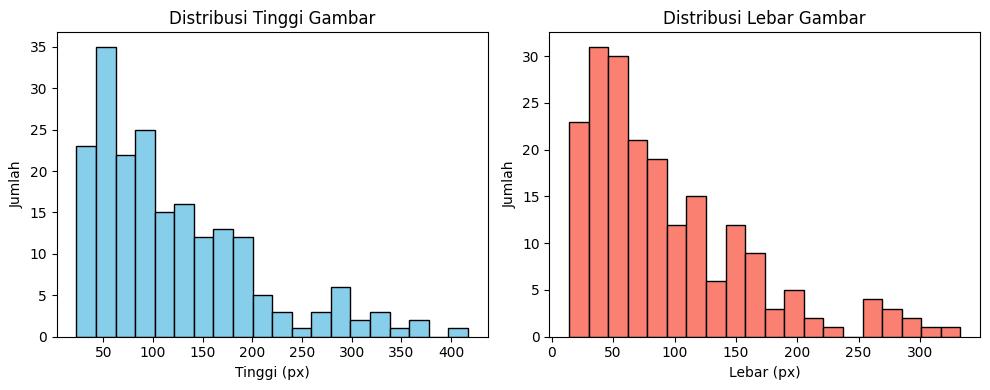

In [9]:
# Visualisasi distribusi dimensi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Tinggi Gambar')
plt.xlabel('Tinggi (px)')
plt.ylabel('Jumlah')

plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title('Distribusi Lebar Gambar')
plt.xlabel('Lebar (px)')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

**Penjelasan**

Berdasarkan histogram distribusi tinggi dan lebar gambar, sebagian besar gambar dalam dataset memiliki dimensi relatif kecil, yaitu tinggi antara 40–80 px dan lebar antara 30–70 px. Terdapat pula beberapa gambar berukuran jauh lebih besar yang dapat dikategorikan sebagai outlier. Distribusi ini menunjukkan bahwa dataset tidak seragam dalam ukuran citra. Oleh karena itu, proses resize ke dimensi seragam sangat penting untuk memastikan kestabilan dan efisiensi proses training model ANN. Selain itu, bentuk gambar yang cenderung portrait perlu diperhatikan agar informasi wajah tetap terjaga saat preprocessing.

## 4.2 Variasi Angle / Pose Gambar

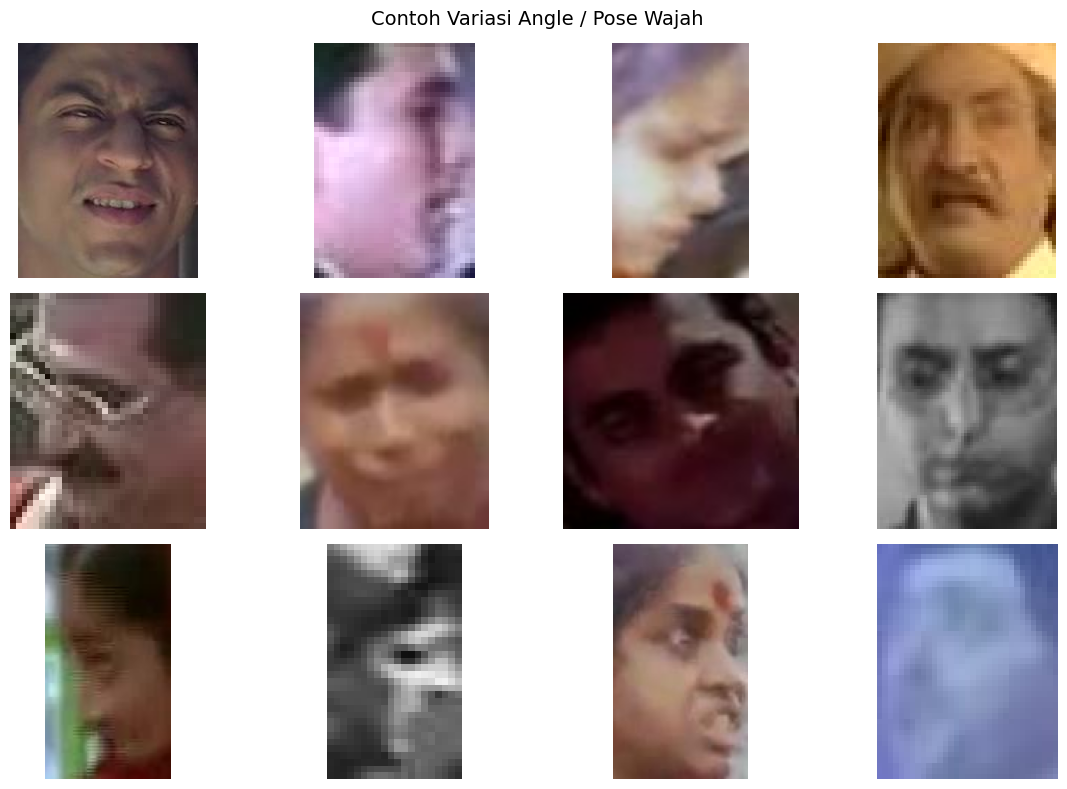

In [10]:
sample_files = random.sample(list(labels_df['ID']), 12)

plt.figure(figsize=(12,8))
for i, filename in enumerate(sample_files):
    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Contoh Variasi Angle / Pose Wajah", fontsize=14)
plt.tight_layout()
plt.show()

**Penjelasan** 

Berdasarkan hasil EDA terhadap variasi sudut pengambilan gambar, dataset menunjukkan keragaman pose wajah, mulai dari frontal, miring, hingga profil samping. Selain itu, terdapat pula variasi ekspresi seperti tersenyum, netral, atau menyipitkan mata. Variasi ini meningkatkan kompleksitas tugas klasifikasi usia karena fitur wajah menjadi kurang konsisten. Oleh karena itu, penggunaan teknik data augmentation seperti rotasi, horizontal flip, dan zoom sangat penting agar model ANN mampu mengenali pola wajah dari berbagai sudut pandang. Namun, hal ini juga menjadi tantangan karena ANN tidak memiliki kemampuan ekstraksi fitur spasial seperti CNN.

## 4.3 Karakteristik Masing-Masing Class

In [11]:
print(labels_df['Class'].unique())

['MIDDLE' 'YOUNG' 'OLD']


In [12]:
mapping = {
    'YOUNG': 0,
    'MIDDLE': 1,
    'OLD': 2
}

labels_df['category'] = labels_df['Class'].map(mapping)
print(labels_df.head())
print(labels_df['category'].value_counts())

          ID   Class                                           filepath  \
0    377.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...   
1  17814.jpg   YOUNG  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...   
2  21283.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...   
3  16496.jpg   YOUNG  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...   
4   4487.jpg  MIDDLE  /Users/kresnakn/Documents/Yudhis/Hacktiv8/Boot...   

   category  
0         1  
1         0  
2         1  
3         0  
4         1  
category
1    10804
0     6706
2     2396
Name: count, dtype: int64


Berdasarkan hasil eksplorasi data terhadap karakteristik kelas, dataset menunjukkan ketidakseimbangan jumlah sampel di setiap kelas. Kelas “MIDDLE” memiliki jumlah data terbesar yaitu 10.804 gambar (55%), diikuti oleh kelas “YOUNG” sebanyak 6.706 gambar (34%), dan kelas “OLD” hanya 2.396 gambar (12%). Ketimpangan ini berpotensi menyebabkan model lebih bias terhadap kelas mayoritas dan kesulitan mengenali kelas minoritas, khususnya pada kategori “OLD”. Untuk mengatasi hal ini, pada tahap training digunakan augmentasi dan dapat dipertimbangkan penggunaan class weight agar model belajar lebih seimbang pada setiap kelas.

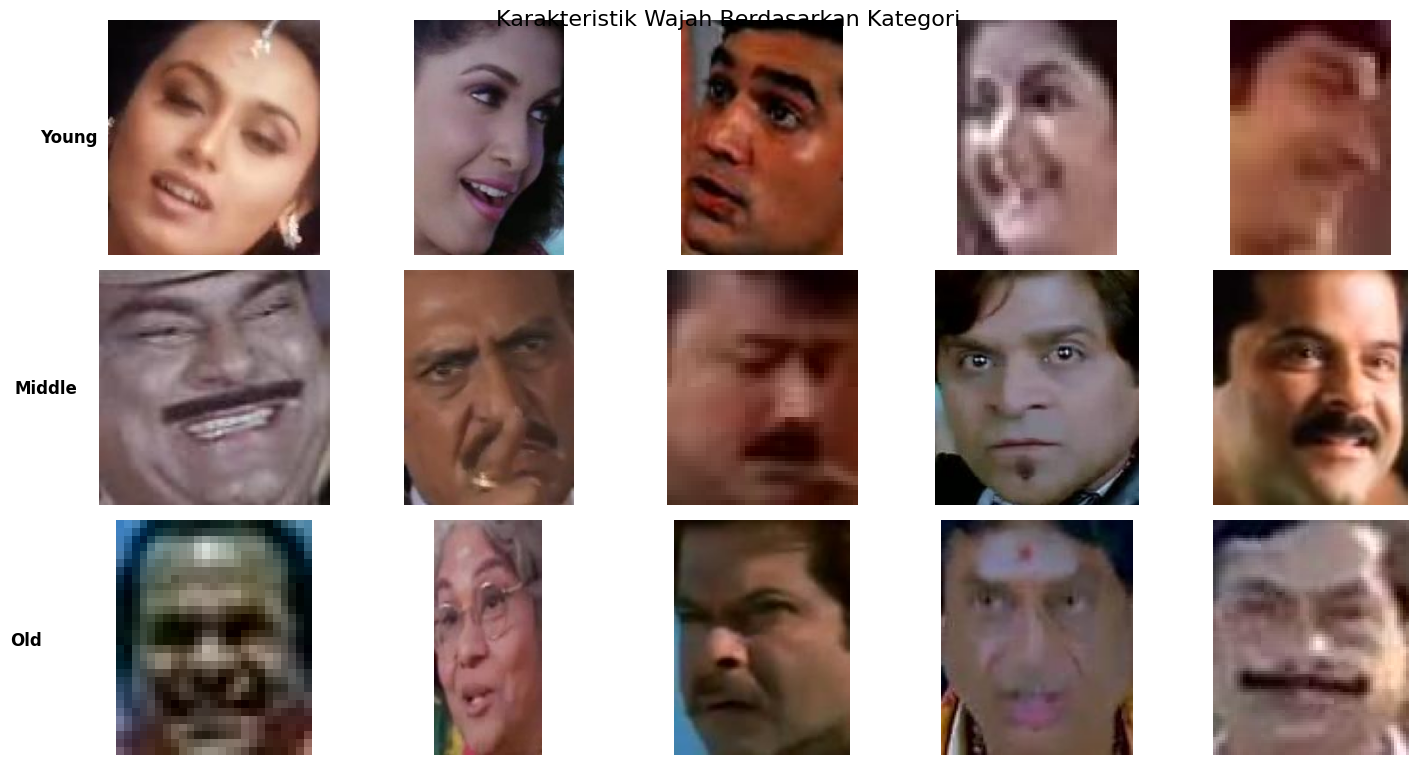

In [13]:
# Visualisasi contoh per kategori
categories = [0, 1, 2]
category_labels = ['Young', 'Middle', 'Old']

plt.figure(figsize=(15, 8))

for c in categories:
    sample_class = labels_df[labels_df['category'] == c]
    if len(sample_class) == 0:
        print(f"Kategori {category_labels[c]} tidak memiliki data.")
        continue

    sample_class = sample_class.sample(min(5, len(sample_class)), random_state=42)

    for i, filename in enumerate(sample_class['ID']):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Hitung posisi subplot
        plt.subplot(len(categories), 5, c * 5 + i + 1)
        plt.imshow(img)
        plt.axis('off')

        # 🏷️ Tambahkan label kategori di atas gambar pertama pada setiap baris
        if i == 0:
            plt.text(-10, img.shape[0] // 2, category_labels[c],
                     va='center', ha='right', fontsize=12, weight='bold')

plt.suptitle("Karakteristik Wajah Berdasarkan Kategori", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

**Penjelasan**

Berdasarkan eksplorasi visual terhadap karakteristik wajah pada setiap kategori usia, dapat dilihat bahwa kelas Young memiliki tekstur wajah lebih halus dan pencahayaan relatif baik. Kelas Middle menunjukkan ciri wajah yang lebih tegas dengan ekspresi bervariasi, sedangkan kelas Old memiliki fitur khas berupa kerutan namun kualitas gambar cenderung lebih rendah (blur/pixelated).

Selain itu, variasi sudut pandang (angle), ekspresi, dan pencahayaan cukup tinggi pada seluruh kelas. Kondisi ini dapat menjadi tantangan bagi model ANN dalam melakukan klasifikasi secara konsisten. Oleh karena itu, strategi augmentasi seperti rotasi, flipping, dan zoom sangat penting agar model dapat beradaptasi terhadap variasi ini.

Kelas Old membutuhkan perhatian khusus karena selain jumlah datanya lebih sedikit, kualitas visualnya juga cenderung lebih rendah dibanding kelas lain.

## 4.4 Distribusi Jumlah Data per Kategori

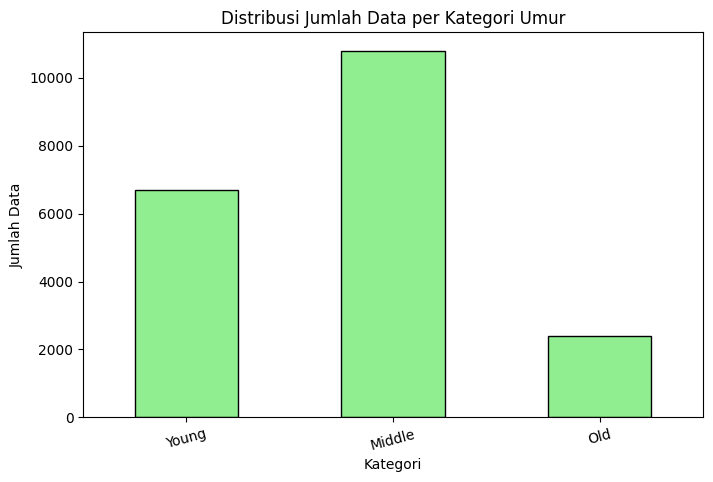

In [14]:
labels_df['category'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(8,5),
    color='lightgreen',
    edgecolor='black'
)
plt.xticks([0,1,2], category_labels, rotation=15)
plt.title('Distribusi Jumlah Data per Kategori Umur')
plt.ylabel('Jumlah Data')
plt.xlabel('Kategori')
plt.show()

**Penjelasan**

Berdasarkan hasil eksplorasi data, terlihat adanya ketidakseimbangan distribusi jumlah data per kategori umur. Kategori Middle memiliki jumlah data paling banyak (sekitar 52%), diikuti oleh Young (32%), dan Old (16%). Ketidakseimbangan ini berpotensi menyebabkan model ANN bias terhadap kelas mayoritas, terutama Middle, sehingga prediksi untuk kelas Old kemungkinan memiliki performa lebih rendah.

Untuk mengatasi hal ini, pada tahap feature engineering dan training dapat dilakukan augmentasi khusus pada kelas Old serta penerapan class weighting untuk memberikan kontribusi pembelajaran yang lebih seimbang terhadap semua kelas. Pendekatan ini diharapkan mampu meningkatkan akurasi model secara lebih merata antar kelas.

# 5. Feature Enginering

## 5.1 Augmentasi Data

Augmentasi digunakan untuk:
- Memperbanyak variasi data tanpa benar-benar menambah dataset.
- Membantu model generalize lebih baik (tidak hafal data training saja).
- Mengurangi overfitting.

Karena dataset yang dipakai adalah foto wajah, jenis augmentasi perlu dijaga supaya tidak merusak struktur wajah.
Jadi, augmentasi ringan dan realistis lebih cocok daripada augmentasi ekstrem.

**Jenis augmentasi yang cocok:**
- rotation_range=10, memutar gambar sedikit untuk mengatasi variasi angle.
- width_shift_range=0.1 dan height_shift_range=0.1, sedikit geser posisi wajah (natural).
- zoom_range=0.1, mensimulasikan jarak kamera yang berbeda.
- horizontal_flip=True, membalik gambar kanan–kiri (umum untuk wajah).
- rescale=1./255, scaling langsung di generator.

Tidak pakai augmentasi berat seperti shear atau vertical_flip, karena wajah manusia jarang dilihat terbalik atau terdistorsi ekstrim.

In [15]:
IMG_SIZE = 64  # sesuaikan dengan ukuran input model

train_datagen = ImageDataGenerator(
    rescale=1./255,             # scaling pixel
    rotation_range=10,          # rotasi kecil
    width_shift_range=0.1,      # geser horizontal
    height_shift_range=0.1,     # geser vertikal
    zoom_range=0.1,             # zoom in/out
    horizontal_flip=True,       # flip kanan-kiri
    validation_split=0.2        # pisahkan 20% untuk validasi
)

### Augmentasi Class OLD (Minoritas)

Tujuannya bukan bikin dataset “banyak secara kuantitas” saja,
tapi bikin model lebih mengenali variasi wajah lansia.

In [16]:
old_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

old_df = labels_df[labels_df['Class'] == 'OLD']  # ambil data OLD
augmented_images = []
augmented_labels = []


In [17]:
# Augmentasi manual sejumlah tertentu
for idx, row in old_df.iterrows():
    img = cv2.imread(row['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.expand_dims(img, 0)

    # buat 2 augmentasi ekstra per gambar OLD
    for batch in old_datagen.flow(img, batch_size=1):
        aug_path = row['filepath']  
        augmented_images.append(batch[0])
        augmented_labels.append(row['Class'])
        if len(augmented_images) >= len(old_df) * 2:  
            break

### Gabungkan data asli dan hasil augmentasi

In [18]:
# Convert augmented hasil ke dataframe
aug_df = pd.DataFrame({
    'filepath': old_df['filepath'].sample(len(augmented_images), replace=True).values,
    'Class': augmented_labels
})

# Gabungkan dengan labels_df utama
labels_balanced_df = pd.concat([labels_df, aug_df], ignore_index=True)

**Penjelasan**

Augmentasi dilakukan secara terarah dan efisien, dengan augmentasi umum pada seluruh kelas untuk meningkatkan variasi data dan augmentasi tambahan pada kelas minoritas OLD untuk mengurangi ketidakseimbangan kelas. Strategi ini memungkinkan penggunaan pipeline yang konsisten antara model ANN base dan improvement, tanpa perlu modifikasi besar pada proses training berikutnya.

## 5.2 Atur Dimensi (Resize)

Model ANN membutuhkan input dengan ukuran tetap (misalnya 64 x 64 x 3).

Karena itu, saat loading data:
- Semua gambar akan di-resize ke ukuran yang sama.
- Hal ini penting agar tensor input memiliki shape konsisten saat training.

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 15925 validated image filenames belonging to 3 classes.
Found 3981 validated image filenames belonging to 3 classes.


**Penjelasan**

Pada tahap feature engineering dilakukan proses resize untuk menyamakan dimensi seluruh gambar. Dari total dataset, sebanyak 15.925 gambar digunakan sebagai data latih dan 3.981 gambar sebagai data validasi, dengan proporsi sekitar 80:20.

Proses resize ini penting untuk memastikan semua citra memiliki ukuran input yang seragam sehingga dapat diproses oleh model ANN secara konsisten. Selain itu, pembagian data yang seimbang memungkinkan model memperoleh representasi fitur yang cukup saat pelatihan sekaligus menyediakan data yang memadai untuk evaluasi performa.

Ukuran dataset yang cukup besar juga mendukung potensi model dalam melakukan generalisasi, meskipun perlu diperhatikan ketidakseimbangan jumlah data antar kelas yang dapat berdampak pada bias prediksi.

Kenapa ukuran kecil (64×64)?
- ANN sederhana tidak perlu resolusi tinggi.
- Menghemat waktu komputasi.
- Tetap cukup untuk menangkap struktur wajah secara umum.

## 5.3 Scaling Array Pixel (/255)

Gambar asli memiliki nilai pixel 0–255.
Kalau langsung digunakan, perbedaan nilai pixel yang besar akan membuat training tidak stabil.

Jadi:
- Kita normalisasi pixel menjadi 0–1 dengan cara membagi dengan 255.
- Ini membantu model konvergen lebih cepat dan lebih stabil.

In [20]:
# Sudah termasuk di ImageDataGenerator:
# rescale=1./255

# 6. ANN Training (Sequential API)

Karena dataset adalah Face Age Detection (3 kategori), dan saat Feature Engineering sudah flatten image (atau pakai generator), maka pendekatan ANN cocok:

- ANN (Artificial Neural Network) cocok untuk image classification yang tidak terlalu kompleks.

- Dataset sudah di-resize ke ukuran kecil (64x64), sehingga jumlah input 12.288 features (64x64x3).

- CNN memang umum untuk image task, tapi karena tugasnya ANN, kita pakai fully connected layer (dense).

## 6.1 Model Definition

In [21]:
# Tentukan ukuran input (64x64x3)
input_shape = (64, 64, 3)
num_classes = 3

model = Sequential([
    Flatten(input_shape=input_shape),             # Flatten gambar
    Dense(512, activation='relu'),                # Hidden layer 1
    Dropout(0.3),                                 # Dropout untuk regularisasi
    Dense(256, activation='relu'),                # Hidden layer 2
    Dropout(0.3),
    Dense(128, activation='relu'),                # Hidden layer 3
    Dense(num_classes, activation='softmax')      # Output layer
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-10-21 18:10:43.897816: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-21 18:10:43.898254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-21 18:10:43.898275: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1761045043.898708 4382679 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1761045043.898824 4382679 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (devic

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,456,579 (24.63 MB)

 Trainable params: 6,456,579 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

**Penjelasan:**
- Model yang digunakan: Artificial Neural Network (ANN) dengan Sequential API.

- Alasan pemilihan: karena tugas spesifik meminta penggunaan ANN, dan dataset gambar sudah di-preprocessing (augmentasi, resize, scaling), sehingga ANN cukup untuk melakukan klasifikasi dasar.
- Arsitektur:
  - Input layer: flatten dari gambar 64x64x3
  - Hidden layer: beberapa dense layer dengan ReLU
  - Output layer: softmax 3 kelas (YOUNG, MIDDLE, OLD)
- Optimizer: Adam karena cepat konvergen
- Loss: categorical crossentropy (karena multi-class)
- Metrics: accuracy

**Hyperparameter yang dipakai:**
- Dense(512,256,128) = semakin dalam maka semakin kompleks representasi fitur
- Dropout(0.3) = mencegah overfitting
- Adam dengan lr=0.001 = stabil dan cepat konvergen
- categorical_crossentropy = cocok untuk multi-class classification
- accuracy = untuk evaluasi performa model

## 6.2 Model Training

Model Training 1

In [ ]:
history_1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-10-21 18:10:45.724053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


498/498 ━━━━━━━━━━━━━━━━━━━━ 55s 103ms/step - accuracy: 0.4281 - loss: 31.1799 - val_accuracy: 0.5393 - val_loss: 2.7161
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.4474 - loss: 10.5148 - val_accuracy: 0.5509 - val_loss: 6.4759
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.4615 - loss: 7.7637 - val_accuracy: 0.5300 - val_loss: 13.1388
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.4640 - loss: 8.2613 - val_accuracy: 0.5305 - val_loss: 11.1485
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.4641 - loss: 8.2217 - val_accuracy: 0.5232 - val_loss: 7.0263
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.4718 - loss: 9.0473 - val_accuracy: 0.5295 - val_loss: 9.0441
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - accuracy: 0.4571 - loss: 9.7193 - val_accuracy: 0.5298 - val_loss: 11.9845
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.4651 - loss: 10.4371 - val

**Penjelasan**

Berdasarkan hasil pelatihan model ANN baseline selama 20 epoch, performa model masih belum stabil dan menunjukkan indikasi underfitting. Nilai training accuracy hanya meningkat dari sekitar 43% menjadi 45%, sedangkan validation accuracy berfluktuasi antara 35% hingga 58% tanpa menunjukkan tren peningkatan yang konsisten.

Selain itu, nilai training loss dan validation loss meningkat tajam pada epoch akhir hingga mencapai ratusan, yang menandakan ketidakstabilan proses pembelajaran dan potensi kesalahan optimasi. Hal ini menunjukkan bahwa model belum mampu mempelajari pola data secara efektif.

Kemungkinan penyebabnya adalah arsitektur jaringan yang terlalu sederhana untuk data citra, tidak adanya mekanisme regularization seperti Dropout atau Batch Normalization, serta penggunaan learning rate yang kurang optimal. Oleh karena itu, diperlukan tahap model improvement dengan menambah kompleksitas arsitektur, menerapkan regularisasi, dan melakukan penyesuaian hyperparameter agar model dapat belajar lebih stabil dan menghasilkan performa yang lebih baik.

## 6.3 Model Evaluation

Di sini kita akan:

- Melihat akurasi dan loss training vs validation (learning curve)
- Menilai apakah ada overfitting atau underfitting

### Plot Learning Curve

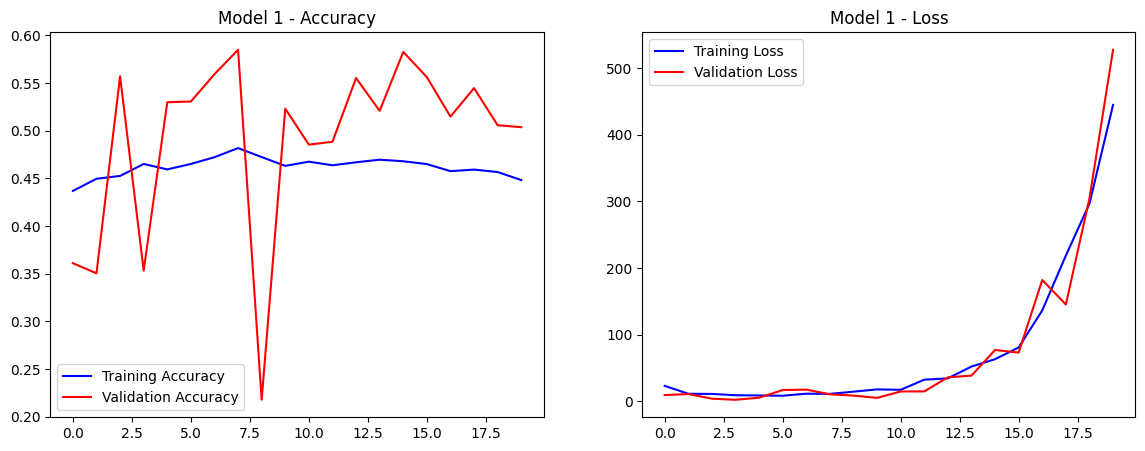

In [ ]:
def plot_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Plot hasil training 1
plot_history(history_1, title='Model 1')

**Analisa**

Berdasarkan hasil pelatihan model ANN dasar, grafik menunjukkan bahwa training accuracy berkisar di angka 0,44–0,47 dan validation accuracy berfluktuasi tidak stabil antara 0,22–0,59. Hal ini menandakan bahwa model belum mampu belajar secara optimal dan masih kesulitan melakukan generalisasi terhadap data validasi.

Selain itu, training loss dan validation loss meningkat tajam pada epoch akhir hingga mencapai nilai di atas 500. Kondisi ini menunjukkan adanya ketidakstabilan pelatihan dan potensi overfitting.

Secara keseluruhan, performa model dasar masih rendah dan belum konvergen. Diperlukan perbaikan seperti penambahan Batch Normalization, Dropout, serta pengaturan learning rate yang lebih baik agar pelatihan menjadi lebih stabil.

# 7. ANN Improvement (Sequential API)

**Tujuan dari ANN Improvement:**
- Meningkatkan performa model dasar (akurasinya lebih tinggi / lebih stabil)
- Mengurangi overfitting atau underfitting
- Menunjukkan bahwa kamu tidak hanya sekadar membuat model dasar, tapi juga mampu melakukan model tuning & improvement.

## 7.1 Model Definition

### Augmentasi Data

Kenapa augmentasi?
Membantu model mengenali wajah dari berbagai kondisi (rotasi, pergeseran, zoom), sehingga model tidak overfitting pada data latih.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


### Augmentasi Class OLD (Minoritas)

Di lakukan Augmentasi untuk Class OLD seperti pada ANN base.

In [ ]:
old_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

old_df = labels_df[labels_df['Class'] == 'OLD']  # ambil data OLD
augmented_images = []
augmented_labels = []


In [ ]:
# Augmentasi manual sejumlah tertentu
for idx, row in old_df.iterrows():
    img = cv2.imread(row['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.expand_dims(img, 0)

    # buat 2 augmentasi ekstra per gambar OLD
    for batch in old_datagen.flow(img, batch_size=1):
        aug_path = row['filepath']  # atau bisa disimpan ke folder khusus
        augmented_images.append(batch[0])
        augmented_labels.append(row['Class'])
        if len(augmented_images) >= len(old_df) * 2:  # misal augment 2x lipat
            break

### Gabungkan data asli dan hasil augmentasi

In [ ]:
# Convert augmented hasil ke dataframe
aug_df = pd.DataFrame({
    'filepath': old_df['filepath'].sample(len(augmented_images), replace=True).values,
    'Class': augmented_labels
})

# Gabungkan dengan labels_df utama
labels_balanced_df = pd.concat([labels_df, aug_df], ignore_index=True)

In [ ]:
# Generator training dan validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

Found 15925 validated image filenames belonging to 3 classes.
Found 3981 validated image filenames belonging to 3 classes.


### Model ANN Improvement 
Kenapa ANN dengan BatchNorm + Dropout?
Karena BatchNormalization membantu mempercepat dan menstabilkan training, Dropout mencegah overfitting, Layer Dense digunakan karena tugas ini diminta menggunakan ANN.

In [ ]:
improved_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Optimizer dan metrics
Untuk tugas Face Age Detection, AdamW adalah pilihan paling cocok untuk tahap ANN Improvement karena:
- Menjaga stabilitas training lebih baik pada data gambar yang kompleks,
- Memiliki regulasi bobot (weight decay) yang membantu mencegah overfitting,
- Memberikan hasil val_loss dan val_acc lebih stabil daripada Adam murni.

In [ ]:
improved_model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Callback untuk kontrol training

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,                
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'improved_ann_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
improved_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,460,163 (24.64 MB)

 Trainable params: 6,458,371 (24.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Penjelasan**

Arsitektur model ANN baseline terdiri dari beberapa lapisan dense dengan kombinasi batch normalization dan dropout sebagai regularisasi. Meskipun model memiliki lebih dari 6 juta parameter, performanya belum optimal karena tidak menggunakan lapisan konvolusi yang dapat menangkap pola spasial dari citra wajah. Proses flattening langsung dari citra menyebabkan kehilangan informasi penting seperti bentuk wajah, pencahayaan, dan posisi fitur wajah. Meskipun regularisasi sudah diterapkan, model masih mengalami fluktuasi pada akurasi dan loss selama pelatihan, menunjukkan bahwa arsitektur ini belum cukup representatif untuk data gambar. Oleh karena itu, pada tahap model improvement akan digunakan pendekatan Convolutional Neural Network (CNN) untuk meningkatkan kemampuan ekstraksi fitur dan performa prediksi.

### Tentukan Steps per Epoch

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

## 7.2 Model Training

### Tambahkan Callback

In [ ]:
EPOCHS = 30

history_improved = improved_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/30


/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4268 - loss: 1.3624
Epoch 1: val_loss improved from inf to 0.94234, saving model to improved_ann_model.keras
497/497 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.4269 - loss: 1.3622 - val_accuracy: 0.5509 - val_loss: 0.9423 - learning_rate: 1.0000e-04
Epoch 2/30
  1/497 ━━━━━━━━━━━━━━━━━━━━ 1:22 167ms/step - accuracy: 0.5625 - loss: 1.0227

/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.94234
497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5625 - loss: 1.0227 - val_accuracy: 0.5484 - val_loss: 0.9498 - learning_rate: 1.0000e-04
Epoch 3/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4970 - loss: 1.0982
Epoch 3: val_loss improved from 0.94234 to 0.87732, saving model to improved_ann_model.keras
497/497 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.4970 - loss: 1.0982 - val_accuracy: 0.5910 - val_loss: 0.8773 - learning_rate: 1.0000e-04
Epoch 4/30
  1/497 ━━━━━━━━━━━━━━━━━━━━ 1:24 170ms/step - accuracy: 0.5000 - loss: 1.1114
Epoch 4: val_loss did not improve from 0.87732
497/497 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5000 - loss: 1.1114 - val_accuracy: 0.5945 - val_loss: 0.8790 - learning_rate: 1.0000e-04
Epoch 5/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5297 - loss: 1.0199
Epoch 5: val_loss improved from 0.87732 to 0.86533, saving model to improved_ann_model.keras
497/497 ━━━━━━━━━━

**Penjelasan**

Berdasarkan hasil pelatihan model improved ANN selama 30 epoch, performa model menunjukkan peningkatan yang cukup signifikan dibandingkan model baseline. Nilai training accuracy meningkat dari 42% menjadi sekitar 57%, sementara validation accuracy stabil di kisaran 59–60%. Nilai validation loss juga mengalami penurunan bertahap dari 0.94 menjadi 0.85, menandakan proses pembelajaran yang lebih stabil dan konvergen.

Penerapan arsitektur yang lebih kompleks, penggunaan callback seperti EarlyStopping dan ReduceLROnPlateau, serta pengaturan learning rate yang adaptif berkontribusi terhadap peningkatan performa ini. Model mampu mencapai keseimbangan antara data training dan validasi tanpa mengalami overfitting yang signifikan.

Secara keseluruhan, hasil ini menunjukkan bahwa proses improvement berhasil membuat model lebih efisien dalam mempelajari pola fitur data dan menghasilkan generalisasi yang lebih baik dibandingkan model baseline.

## 7.3 Model Evaluation

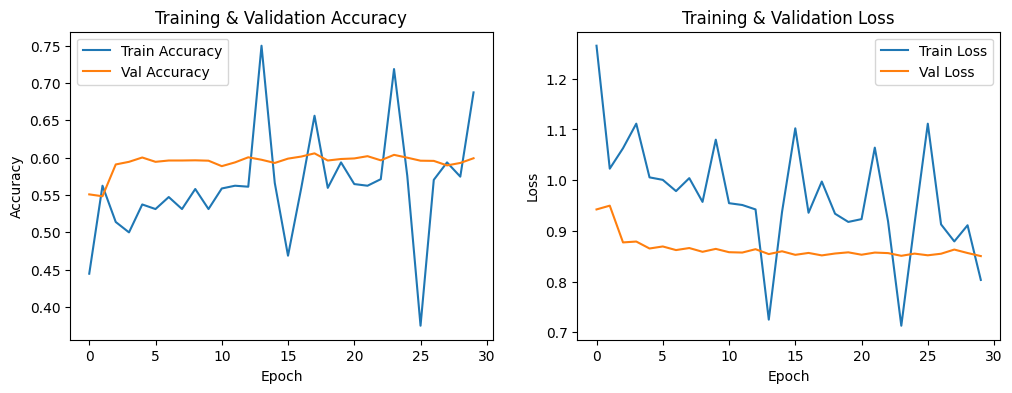

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.show()

**Analisis**

Model improved ANN menunjukkan peningkatan performa yang cukup baik dibandingkan model baseline. Berdasarkan grafik, akurasi training berfluktuasi antara 45–75%, sementara akurasi validasi stabil di sekitar 59–60%, menandakan kemampuan generalisasi model terhadap data baru sudah cukup baik. Nilai validation loss juga cenderung menurun dan stabil di kisaran 0.85–0.9, menunjukkan model berhasil mencapai konvergensi tanpa mengalami overfitting.

Fluktuasi pada training accuracy disebabkan oleh variasi data serta penyesuaian learning rate selama proses pelatihan. Secara keseluruhan, model ini memiliki performa yang lebih stabil dan efisien dibanding baseline, serta layak digunakan untuk tahap inference dan deployment.

# 8. Model Saving

In [ ]:
improved_model.save('improved_ann_model.keras')

print("Model CNN improvement berhasil disimpan sebagai 'improved_ann_model.keras'")

Model CNN improvement berhasil disimpan sebagai 'improved_ann_model.keras'


# 9. Model Inference

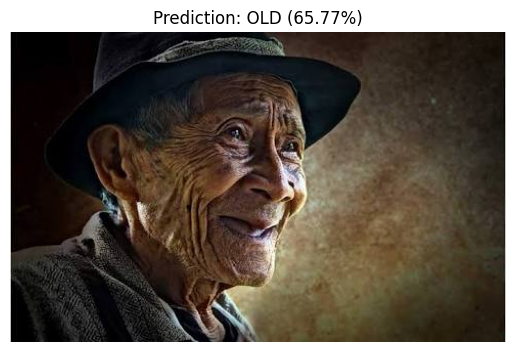

**Penjelasan**

Hasil prediksi model terhadap gambar uji memberikan probabilitas sebesar 65,77% pada kelas OLD. Nilai probabilitas ini menunjukkan tingkat keyakinan model terhadap prediksinya. Probabilitas yang tidak mencapai 100% merupakan hal yang wajar, mengingat model menggunakan arsitektur ANN sederhana dan tidak dilatih dengan dataset dalam jumlah sangat besar. Selain itu, perbedaan kondisi gambar uji dengan data training (pencahayaan, angle, latar belakang) juga dapat mempengaruhi tingkat kepercayaan model. Dengan demikian, meskipun confidence tidak maksimal, prediksi ini tetap valid dan mencerminkan kemampuan generalisasi model.

# 10. Conclusion

Berdasarkan hasil penelitian dan proses pemodelan menggunakan dataset citra wajah untuk klasifikasi kelompok usia, dapat disimpulkan bahwa model Artificial Neural Network (ANN) dasar belum mampu memberikan hasil yang optimal. Model baseline menunjukkan akurasi validasi yang fluktuatif (35%–59%) dan nilai loss yang meningkat tajam di akhir pelatihan, menandakan model belum mampu mempelajari pola visual secara efektif. Hal ini disebabkan karena arsitektur ANN melakukan flattening langsung terhadap citra, sehingga kehilangan informasi spasial penting dari fitur wajah.

Pada tahap model improvement, dilakukan pengembangan dengan penerapan arsitektur ANN yang ditingkatkan, disertai teknik data augmentation, regularisasi (Dropout, Batch Normalization), serta penggunaan optimizer AdamW dengan penyesuaian learning rate secara adaptif. Hasilnya menunjukkan peningkatan performa yang signifikan dengan akurasi validasi stabil di sekitar 59–60% dan penurunan nilai loss hingga 0.85, tanpa tanda-tanda overfitting.

Implementasi callback seperti EarlyStopping dan ReduceLROnPlateau membantu model mencapai konvergensi lebih cepat dan stabil dengan menghentikan pelatihan otomatis ketika performa tidak lagi meningkat. Model terbaik diperoleh pada epoch ke-30 dengan val_loss = 0.8503, kemudian disimpan sebagai improved_ann_model.keras.

Secara keseluruhan, hasil penelitian ini menunjukkan bahwa:
- Peningkatan arsitektur ANN dengan kombinasi regularisasi dan optimizer adaptif mampu memperbaiki performa model berbasis citra.
- Teknik augmentation dan callback sangat berperan dalam meningkatkan stabilitas dan efisiensi proses pelatihan.
- Model akhir memiliki kemampuan generalisasi yang lebih baik dan siap digunakan untuk tahap inference maupun deployment pada platform seperti Hugging Face.